In [2]:

import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import scipy.io 
import mne
import os
import sys
sys.path.insert(0, 'E:/workspace/my_py_toolbox/')
from hm_tools import *

behavior_path = r"E:/workspace/sEEG_slow_fast_attack/event/"

in_path = r"E:/workspace/sEEG_slow_fast_attack/roi_data/amy/" # 分析哪个roi就输入哪个文件夹的数据

# subjects = [104, 108, 116, 117, 119, 120] # vmpfc 
subjects= [104, 108, 113, 116, 117, 119, 120, 122] # amy 
# subjects = [104, 108, 109, 112, 113, 116, 117, 119, 120, 124]  # hippo 
# subjects = [109, 116, 119, 120, 122] # striatum  
# subjects = [104, 119, 122, 123, 124] # mcc    
# subjects = [104, 108, 109, 112, 113, 116, 117, 119, 120, 122, 124] # insula


def gaussian_filter(data, time_span=50, fs=1000, axis=-1):

    # time_span: the length of the window (ms)
    from scipy import signal, ndimage

    winsize = time_span * fs / 1000

    # create a window(kernel) with value follow a gaussian distrubution
    window = signal.gaussian(winsize,std = int((winsize)/5) ) # Note! In matlab function 'gausswin',the parameter is α(defaut = 2.5), here is std, std = winsize/2α

    # Make the sum of the window = 1
    gusWin = window/sum(window)

    # convolve the last dimension
    data_filtered = ndimage.convolve1d(input=data, weights=gusWin, axis=axis, mode='nearest', origin=0)

    return data_filtered

In [17]:
from mne.time_frequency import tfr_morlet

# fast escaped trials '1/5/6'
# fast captured trials '2/5/7/8'
# slow escaped trials '3/5/6'
# slow premature trials '10/5/6'
# slow captured trials '4/5/7/8'


freqs=np.arange(70, 120, 5)
n_cycles=10
time_span = 100
ch_names = []
decision_time_range = [-0.5, 0.4] # before and after decision  0.9
baseline_range = [-0.2, 0.1]  # before and after baseline 0.3s

# time series
time_range = np.arange(baseline_range[0]-baseline_range[1] + decision_time_range[0], decision_time_range[1], 0.001)
for i in range(len(subjects)):

    # import eeg data
    ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
    # correct some wrong event number
    if subjects[i]==108:
        ROI_epochs.events[61, 2] = 3
    if subjects[i]==119:
        ROI_epochs.events[49, 2] = 1
    if subjects[i]==109:
        ROI_epochs.events[4, 2] = 1
    # import event inform
    each_trial_information = pd.read_table(behavior_path + str(subjects[i]) + "each_trial_information.txt", delimiter=" ")
    fast_trial_information = each_trial_information[each_trial_information['trial_condition']==1]
    slow_trial_information = each_trial_information[each_trial_information['trial_condition']==3]
    # calculate tfr
    tfr_ROI_epoch_fast = tfr_morlet(ROI_epochs['1/5/6'], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)
    tfr_ROI_epoch_slow = tfr_morlet(ROI_epochs['3/5/6'], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)

    # cut the baseline range  baseline_range
    tfr_ROI_epoch_fast_baseline_data = tfr_ROI_epoch_fast.copy().crop(baseline_range[0], baseline_range[1]).data
    tfr_ROI_epoch_slow_baseline_data = tfr_ROI_epoch_slow.copy().crop(baseline_range[0], baseline_range[1]).data

    # fast attack
    # Divide the decision response into two conditions for pre - and post capture, followed by alignment, and then generate new mne tfr data
    for iter_trial in range(tfr_ROI_epoch_fast_baseline_data.shape[0]):

        # Determine the time window to be intercepted for each trial by combining the data from each trial
        iter_trialtime = decision_time_range + np.array(fast_trial_information['escape_time'])[iter_trial]
        # cut the data
        iter_fast_decision_data = tfr_ROI_epoch_fast.copy()[iter_trial].crop(iter_trialtime[0], iter_trialtime[1]-0.001).data

        # load the data 
        if iter_trial == 0: 
            iter_subject_fast_decision_data = iter_fast_decision_data
        else: 
            iter_subject_fast_decision_data = np.vstack((iter_subject_fast_decision_data, iter_fast_decision_data))

    # slow attack
    discarded_trial = []
    empty_or_not = 0
    for iter_trial in range(tfr_ROI_epoch_slow_baseline_data.shape[0]):

        # Determine the time window to be intercepted for each trial by combining the data from each trial
        iter_trialtime = decision_time_range + np.array(slow_trial_information['escape_time'])[iter_trial]
        if iter_trialtime[1] < 4-0.5: # A trial that takes too long won't be needed
            # cut the data
            iter_slow_decision_data = tfr_ROI_epoch_slow.copy()[iter_trial].crop(iter_trialtime[0], iter_trialtime[1]-0.001).data

            # load the data
            if empty_or_not == 0: 
                iter_subject_slow_decision_data = iter_slow_decision_data
                empty_or_not = 1
            else: 
                iter_subject_slow_decision_data = np.vstack((iter_subject_slow_decision_data, iter_slow_decision_data))
        else:
            discarded_trial.append(iter_trial)

    # Merge data from base segment and selection segment, delete data that is too long in slow attack trials
    iter_subject_fast_data = np.concatenate((tfr_ROI_epoch_fast_baseline_data, iter_subject_fast_decision_data), axis=3)
    iter_subject_slow_data = np.concatenate((np.delete(tfr_ROI_epoch_slow_baseline_data, discarded_trial, axis=0), iter_subject_slow_decision_data), axis=3)

    # Prepare the tfr file for generating mne for baseline correction
    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    # Average all trials
    all_fast_mean_data = np.mean(iter_subject_fast_data, axis=0)
    all_slow_mean_data = np.mean(iter_subject_slow_data, axis=0)
    # Generate tfr files for mne
    all_fast_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=all_fast_mean_data, times=time_range, freqs=freqs, nave=1)
    all_slow_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=all_slow_mean_data, times=time_range, freqs=freqs, nave=1)

    # 
    all_fast_mean_tfr.apply_baseline(mode='logratio', baseline=(baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.1, baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.2)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
    all_slow_mean_tfr.apply_baseline(mode='logratio', baseline=(baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.1, baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.2)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
    # Gaussian filter
    smooth_hgb_fast_data = gaussian_filter(data=np.mean(all_fast_mean_tfr.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    smooth_hgb_slow_data = gaussian_filter(data=np.mean(all_slow_mean_tfr.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    # 得到的数据: trial, channel, time
  
    if i == 0:
        all_smooth_hgb_fast_data = smooth_hgb_fast_data
        all_smooth_hgb_slow_data = smooth_hgb_slow_data
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        all_smooth_hgb_fast_data = np.vstack((all_smooth_hgb_fast_data, smooth_hgb_fast_data))
        all_smooth_hgb_slow_data = np.vstack((all_smooth_hgb_slow_data, smooth_hgb_slow_data))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

    print(smooth_hgb_slow_data.shape)

Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/104.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


Not setting metadata
Not setting metadata


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(1, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/108.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(3, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/113.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(3, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/116.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(4, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/117.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(5, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/119.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(7, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/120.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(6, 1201)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/122.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata


<ipython-input-17-c5c21fe62b68>:22: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
(3, 1201)


In [18]:
all_smooth_hgb_fast_data.data.shape

(32, 1201)

In [19]:
all_smooth_hgb_slow_data

array([[ 0.2475419 ,  0.24784527,  0.24811758, ..., -0.03131388,
        -0.0304748 , -0.02965706],
       [ 0.16985491,  0.16908494,  0.1682489 , ...,  0.01214355,
         0.01351492,  0.01487054],
       [ 0.11127246,  0.11066241,  0.11002291, ..., -0.00262148,
        -0.00314814, -0.00368294],
       ...,
       [-0.07888985, -0.07706799, -0.07514442, ..., -0.14912859,
        -0.14912667, -0.14911661],
       [-0.08794623, -0.08636739, -0.08466551, ...,  0.01937694,
         0.02085236,  0.02228108],
       [-0.04175185, -0.04133138, -0.04089518, ..., -0.00415308,
        -0.00447905, -0.00483657]])

In [23]:
# create a new epochs info
info_fast = mne.create_info(ch_names = list(np.arange(all_smooth_hgb_fast_data.shape[0]).astype('str')), ch_types = 'eeg', sfreq = 1000)
info_slow = mne.create_info(ch_names = list(np.arange(all_smooth_hgb_slow_data.shape[0]).astype('str')), ch_types = 'eeg', sfreq = 1000)

# create a new ROI based epochs
all_smooth_hgb_fast = mne.EvokedArray(data = all_smooth_hgb_fast_data, info = info_fast, tmin=baseline_range[0]-baseline_range[1]+decision_time_range[0])
all_smooth_hgb_slow = mne.EvokedArray(data = all_smooth_hgb_slow_data, info = info_slow, tmin=baseline_range[0]-baseline_range[1]+decision_time_range[0])
all_smooth_hgb_fast.apply_baseline(baseline=(baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.1, baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.2))
all_smooth_hgb_slow.apply_baseline(baseline=(baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.1, baseline_range[0]-baseline_range[1]+decision_time_range[0]+0.2))

times = all_smooth_hgb_slow.times

all_smooth_hgb_fast_crop = all_smooth_hgb_fast
all_smooth_hgb_slow_crop = all_smooth_hgb_slow

all_smooth_hgb_fast_crop = all_smooth_hgb_fast_crop.crop(-0.4, 0.4)
all_smooth_hgb_slow_crop = all_smooth_hgb_slow_crop.crop(-0.4, 0.4) 

n_permutations = 10000

# 两种情况下相对于0的显著性
T_obs_fast, clusters_fast, cluster_p_values_fast, H0_fast  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_fast_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, n_jobs=6, tail=0, verbose=None)

T_obs_slow, clusters_slow, cluster_p_values_slow, H0_slow  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_slow_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, n_jobs=6, tail=0, verbose=None)

# 两者之间的显著性
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_slow_crop.data, all_smooth_hgb_fast_crop.data],
                                                                out_type='mask', n_permutations=n_permutations, n_jobs=6,tail=0
                                                                ,verbose=None) 


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Using a threshold of 2.039513
stat_fun(H1): min=0.161672 max=5.496032
Running initial clustering
Found 7 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12081.08it/s]


Computing cluster p-values
Done.
Using a threshold of 2.039513
stat_fun(H1): min=-3.245949 max=2.834216
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 13267.43it/s]


Computing cluster p-values
Done.
Using a threshold of 3.995887
stat_fun(H1): min=0.000001 max=17.954852
Running initial clustering
Found 4 clusters
Permuting 9999 times...


<ipython-input-23-074d36f4fed5>:29: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_slow_crop.data, all_smooth_hgb_fast_crop.data],
100%|██████████|  : 9999/9999 [00:00<00:00, 10596.43it/s]

Computing cluster p-values
Done.


In [21]:
all_smooth_hgb_slow_crop.data.shape

(32, 801)

(array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

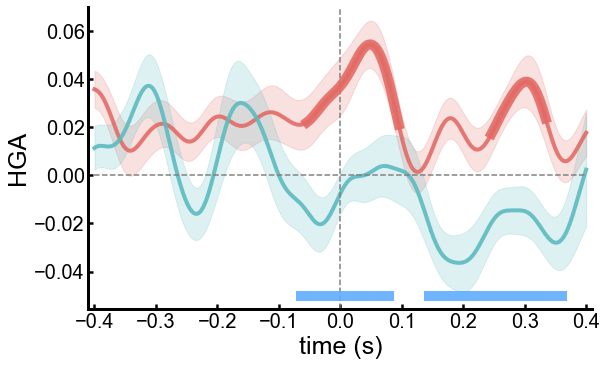

In [25]:
line_color = ['#E36A65','#5CBBBF']
figsize=(10,6) 
title_size=20
legend_size=15

ticksize=10
subplots_adjust=[0.15, 0.15, 0.85, 0.85]


import matplotlib.pyplot as plt
import numpy as np
import os

event_0_line_color = line_color[0]
event_1_line_color = line_color[1]

# the number of time axis
times = all_smooth_hgb_slow.times

plt.close('all')
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
# plt.title('ROI: '+ roi_name, fontdict={'fontsize':title_size})

epoch_mean={}
epoch_mean[0] = np.squeeze(np.average(all_smooth_hgb_fast.data, axis=0))
epoch_mean[1] = np.squeeze(np.average(all_smooth_hgb_slow.data, axis=0))

plt.plot(times, epoch_mean[0], color=line_color[0], alpha=0.9, linewidth=4) # , linestyle='--')
plt.plot(times, epoch_mean[1], color=line_color[1], alpha=0.9, linewidth=4) # , linestyle='--')


plt.axvline(times[400], c="gray", ls = "dashed")
plt.plot(times, np.zeros(len(epoch_mean[0])), color="gray", linestyle="--")


std_event0 = np.squeeze(np.std(all_smooth_hgb_fast.data, axis=0))
std_event1 = np.squeeze(np.std(all_smooth_hgb_slow.data, axis=0))

se_event0 = std_event0/np.sqrt(all_smooth_hgb_fast.data.shape[0])
se_event1 = std_event1/np.sqrt(all_smooth_hgb_slow.data.shape[0])

plt.fill_between(times, epoch_mean[0] - se_event0, epoch_mean[0] + se_event0, color=line_color[0], alpha=0.2)
plt.fill_between(times, epoch_mean[1] - se_event1, epoch_mean[1] + se_event1, color=line_color[1], alpha=0.2)

# condition 0 to baseline
for i_c, c in enumerate(clusters_fast):
    c = c[0]
    if cluster_p_values_fast[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[0][c.start : c.stop-1], color=event_0_line_color, alpha=0.9, linewidth=10)
# condition 1 to baseline
for i_c, c in enumerate(clusters_slow):
    c = c[0]
    if cluster_p_values_slow[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[1][c.start : c.stop-1], color=event_1_line_color, alpha=0.9, linewidth=10)

# condition 0 and condition 1
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        
        plt.plot(times[c.start : c.stop - 1], -0.05 * np.ones(len(epoch_mean[0]))[c.start : c.stop-1], color='#5EACFF', alpha=0.9, linewidth=10)


plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3], hspace=0.1,wspace=0.1)

plt.xlim([times[0]-0.01, times[-1]+0.01])

plt.yticks(size=ticksize)
plt.xticks(size=ticksize)

spines_width = 3
ax=plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(spines_width)
ax.spines['bottom'].set_linewidth(spines_width)


# 坐标轴刻度粗细,朝内
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# plt.set_ylabel("Escape Accuracy", size=ticksize, fontproperties='Arial')

labelsize=25
plt.xlabel("time (s)", fontsize=labelsize, fontproperties='Arial')
plt.ylabel("HGA", size=labelsize, fontproperties='Arial')

# 坐标的粗细
ticksize = 20
plt.yticks(size=ticksize, fontproperties='Arial')
plt.xticks(size=ticksize, fontproperties='Arial')
# plt.savefig(r'D:\Desktop\项目\seeg\画图\hga_all\mcc_decision.jpg',dpi=300, overwrite=True)
# plt.savefig(result_path + '/' + permutation_cluster_result['ROI_name'][ROI_num] + ".png", overwrite=True)